In [1]:
#imports

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

plt.style.use("/Users/achro/Downloads/CJ_style.mplstyle")

# Part 1: Inference

In [2]:
"""
Here I am considering how to find the best fit model of some data which are known
to follow a linear relationship. In this case, data for distance vs. time.
I consider how to do this with and without considering the uncertainties in the data.
"""

np.random.seed(16) # set seed for reproducability

t = np.arange(10) # data taken at 10, equally spaced intervals

d = 2*t + 5 + np.random.randn(10) # generate distances with random, Gaussian scatter

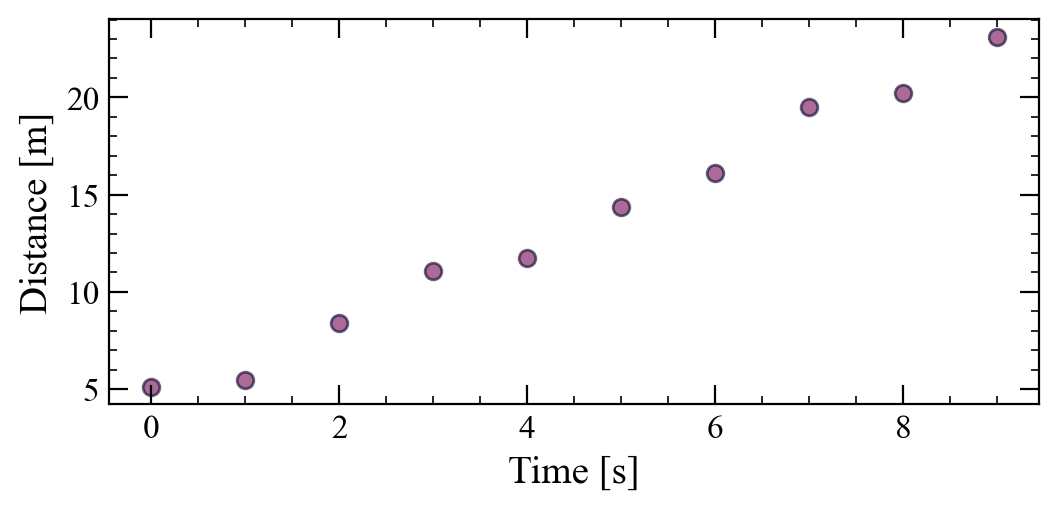

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))

ax.scatter(t, d, color='xkcd:velvet', edgecolor='xkcd:midnight', alpha=0.6)

ax.set_ylabel('Distance [m]')
ax.set_xlabel('Time [s]')

plt.show()

In [4]:
"""
By inspecting the graph, I can guess at a prior distribution of slopes and intercepts
"""

slope_prior = np.linspace(1, 3, 101) # array of slopes between 1 and 3
intercept_prior = np.linspace(4, 6, 101) # array of intercepts between 4 and 6


In [5]:
"""
Here, I define two convenience functions: one to implement any given model 
(i.e., pair of slope and intercept), and one for the sum of squared errors.
"""

def linear_model(t, slope, intercept):
    return t * slope + intercept # y = mx + b

def sum_sqr_err(t, slope, intercept, dobs):
    return np.sum((dobs - linear_model(t, slope, intercept))**2)

In [6]:
# compute n x n array of square errors for each combination of slope and intercept

sqr_err = np.array([[sum_sqr_err(t, m, b, d) for b in intercept_prior] for m in slope_prior])
# list comprehension... note that this creates a matrix where the first index is the slope and the
# second is the intercept. The nesting goes "from the outside in".

In [7]:
"""
One way to determine the "best-fit" model is to determine the pair of slope-intercept values
that has the smallest squared error. I can do that by looking for the index into the array of squared
errors where the minimum value is located
"""

idx = np.unravel_index(sqr_err.argmin(), sqr_err.shape)

bestm = slope_prior[idx[0]]
bestb = intercept_prior[idx[1]]

bestm, bestb

(2.06, 4.24)

In [8]:
sqr_err[idx]

3.747141631566637

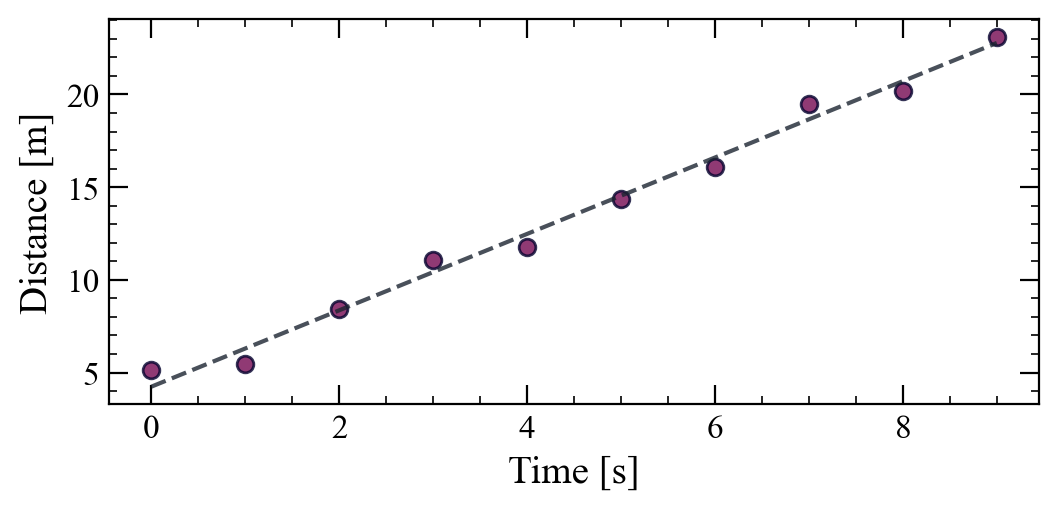

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))

ax.scatter(t, d, color='xkcd:velvet', edgecolor='xkcd:midnight', alpha=0.8)

ax.plot(t, t * bestm + bestb, color='xkcd:dark', ls='--', alpha=0.8)

ax.set_ylabel('Distance [m]')
ax.set_xlabel('Time [s]')

plt.show()

In [10]:
"""
The above did not consider the uncertainties on the measurements. I can consider the uncertainties
in the measurements by giving more weight to datapoints with lower uncertainties. I'll do this by
modifying the error function with an inverse weight on uncertainties. This is the famous chi squared.
"""

np.random.seed(10) #reproducability
d_err = np.random.randn(10) * np.sqrt(2)

def chi2(t, m, b, dobs, err):
    return np.sum(((dobs - linear_model(t, m, b))**2 / err*2))

In [11]:
chi2_arr = np.array([[chi2(t, m, b, d, d_err) for b in intercept_prior] for m in slope_prior])

idx = np.unravel_index(chi2_arr.argmin(), chi2_arr.shape)

bestm_err, bestb_err = slope_prior[idx[0]], intercept_prior[idx[1]]

bestm_err, bestb_err

(2.0, 4.0)

In [12]:
chi2_arr[idx]

-156.0402808892757

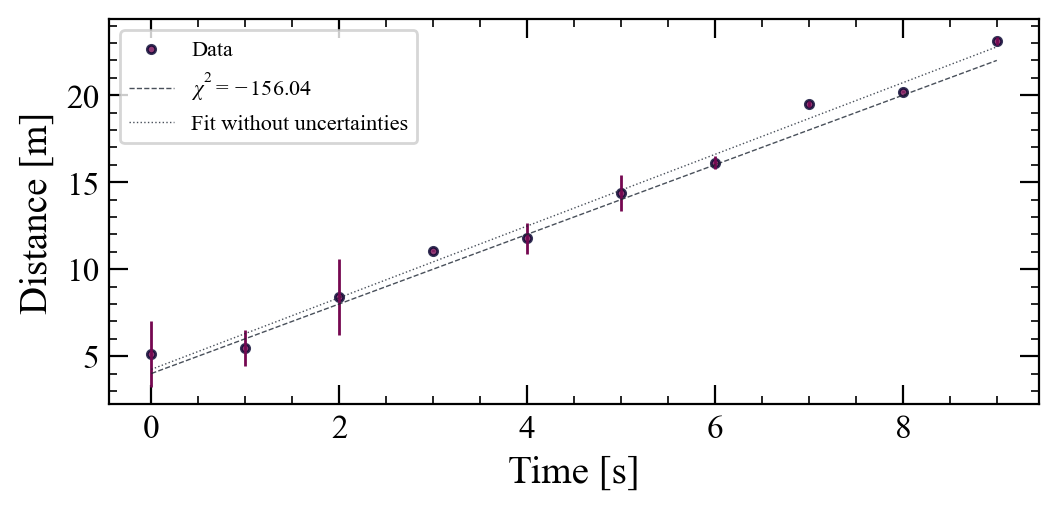

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))

ax.scatter(t, d, color='xkcd:velvet', edgecolor='xkcd:midnight', alpha=0.8, marker='.', label='Data')
plt.errorbar(t, d, np.abs(d_err), fmt='None', color='xkcd:velvet', lw=1)
ax.plot(t, t * bestm_err + bestb_err, color='xkcd:dark', ls='--', alpha=0.8, lw=0.5, 
        label=f'$\chi^2 = {chi2_arr[idx].round(2)}$')
ax.plot(t, t * bestm + bestb, color='xkcd:dark', ls='dotted', alpha=0.8, lw=0.5, 
        label='Fit without uncertainties')

ax.legend()
ax.set_ylabel('Distance [m]')
ax.set_xlabel('Time [s]')

plt.show()

# Part 2: Machine Learning

In [14]:
"""
Fitting a line to some data is a regression problem, so I need to consider ML algorithms which
can handle regression. Two algorithms of use are the linear-regressor and decission tree.
"""

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split #helper for splitting up the test/train set

In [15]:
np.random.seed(10)

X_train, X_test, y_train, y_test = train_test_split(t, d, test_size=3)

In [16]:
treemodel = DecisionTreeRegressor() #using default parameters
regmodel = LinearRegression() #using default parameters

In [17]:
"""
The basic idea now is to train my algorithms, defined above, on the training set,
then to use the algorithm to predict the output for the test set.
"""

#the two methods have the same syntax
y_pred_tree = treemodel.fit(X_train.reshape(-1, 1), y_train).predict(X_test.reshape(-1, 1))
y_pred_reg = regmodel.fit(X_train.reshape(-1, 1), y_train).predict(X_test.reshape(-1, 1))

In [18]:
"""
Now I am in a position to compare the results of the two models to the "true" values,
i.e., the test set and compute the errors.
"""

y_test, y_pred_reg, y_pred_tree

(array([20.2131029 ,  8.40553202, 14.37863139]),
 array([20.89464175,  8.40922424, 14.651933  ]),
 array([19.49890986,  5.47152654, 11.76450513]))

In [19]:
np.mean((y_test - y_pred_reg)**2), np.mean((y_test - y_pred_tree)**2)

(0.17973420210564217, 5.317371993292266)

In [20]:
"""
In this example, the linear regressor does a much better job than the decision tree,
at least when it comes to predicting the test set. Regardless, both models are in a sense
ready to make predictions. 
"""
# Predict the distance after t=12s

reg_prediction = treemodel.predict(np.array([12]).reshape(-1, 1))
tree_prediction = regmodel.predict(np.array([12]).reshape(-1, 1))

reg_prediction[0], tree_prediction[0], 2*12+5

(23.118743563764912, 29.218253421813735, 29)